In [44]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
import numpy as np

def one_hot_encode(labels, num_classes=10):
    """
    Converts integer labels to one-hot encoded vectors.

    Args:
        labels (numpy.ndarray): Array of integer labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: One-hot encoded labels.
    """
    return np.eye(num_classes)[labels].reshape(-1, num_classes)

class Neuron:
    def __init__(self, nin, activation=None):
        """
        Initializes a neuron with random weights and bias.

        Args:
            nin (int): Number of inputs to the neuron.
            activation (str): Activation function to use ('sigmoid', 'relu', 'tanh', or 'linear').
        """
        if activation in ['relu']:
            std = np.sqrt(2. / nin)
        elif activation in ['tanh', 'sigmoid']:
            std = np.sqrt(1. / nin)
        else:
            std = np.sqrt(1. / nin)
        self.weights = np.random.normal(0, std, nin)
        self.bias = 0.0  # Initialize bias to zero
        self.activation = activation

        self.input_values = None
        self.weighted_sum = 0.0
        self.output_value = 0.0

        self.weight_gradients = np.zeros(nin)
        self.bias_gradient = 0.0
        self.input_gradients = np.zeros(nin)

    def activate(self, z):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation == 'relu':
            return np.maximum(0.0, z)
        elif self.activation == 'tanh':
            return np.tanh(z)
        else:
            return z  # linear activation

    def activation_derivative(self, activated_output):
        if self.activation == 'sigmoid':
            return activated_output * (1 - activated_output)
        elif self.activation == 'relu':
            return 1.0 if activated_output > 0 else 0.0
        elif self.activation == 'tanh':
            return 1 - activated_output ** 2
        else:
            return 1.0  # derivative of linear activation

    def forward(self, input_values):
        """
        Performs the forward pass for the neuron.

        Args:
            input_values (numpy.ndarray): Inputs to the neuron.

        Returns:
            float: Output after applying activation function.
        """
        self.input_values = input_values
        self.weighted_sum = np.dot(self.weights, input_values) + self.bias
        self.output_value = self.activate(self.weighted_sum)
        return self.output_value

    def backward(self, gradient_from_above):
        """
        Performs the backward pass for the neuron.

        Args:
            gradient_from_above (float): Gradient from the next layer.

        Returns:
            numpy.ndarray: Gradient to pass to the previous layer.
        """
        activation_derivative = self.activation_derivative(self.output_value)
        gradient_weighted_sum = gradient_from_above * activation_derivative

        # Compute gradients for weights and bias
        self.weight_gradients = gradient_weighted_sum * self.input_values
        self.bias_gradient = gradient_weighted_sum

        # Compute gradients for inputs to propagate to previous layer
        self.input_gradients = gradient_weighted_sum * self.weights
        return self.input_gradients

class Layer:
    def __init__(self, units, nin, activation=None):
        """
        Initializes a layer with a specified number of neurons.

        Args:
            units (int): Number of neurons in the layer.
            nin (int): Number of inputs each neuron receives.
            activation (str): Activation function for the neurons ('sigmoid', 'relu', 'tanh', 'linear', 'softmax').
        """
        self.activation = activation
        self.neurons = [Neuron(nin, activation=None if activation == 'softmax' else activation) for _ in range(units)]
        self.output_values = None

    def forward(self, input_values):
        """
        Performs the forward pass for the layer.

        Args:
            input_values (numpy.ndarray): Inputs to the layer.

        Returns:
            numpy.ndarray: Outputs from the layer.
        """
        # Collect outputs from all neurons in the layer
        neuron_outputs = np.array([neuron.forward(input_values) for neuron in self.neurons])

        if self.activation == 'softmax':
            # Softmax will be handled separately in the MLP class
            self.output_values = neuron_outputs
        else:
            self.output_values = neuron_outputs

        return self.output_values

    def backward(self, gradients_from_above, clip_value=1.0):
        """
        Performs the backward pass for the layer.

        Args:
            gradients_from_above (numpy.ndarray): Gradients from the next layer.

        Returns:
            numpy.ndarray: Gradients to pass to the previous layer.
        """
        gradients_to_previous_layer = np.zeros_like(self.neurons[0].input_gradients)
        
        for neuron, grad in zip(self.neurons, gradients_from_above):
            clipped_grad = np.clip(grad, -clip_value, clip_value)
            neuron_input_gradients = neuron.backward(clipped_grad)
            gradients_to_previous_layer += neuron_input_gradients
    
        return gradients_to_previous_layer

    def update_parameters(self, learning_rate):
        """
        Updates the parameters (weights and biases) of all neurons in the layer.

        Args:
            learning_rate (float): Learning rate for the update step.
        """
        for neuron in self.neurons:
            # Update weights and biases using gradients
            neuron.weights -= learning_rate * neuron.weight_gradients
            neuron.bias -= learning_rate * neuron.bias_gradient

class MLP:
    def __init__(self, layer_sizes, activation_functions):
        """
        Initializes the Multi-Layer Perceptron.
        """
        assert len(layer_sizes) - 1 == len(activation_functions), "Mismatch between layer sizes and activation functions."
        self.loss_history = []
        self.layers = []
        for i in range(1, len(layer_sizes)):
            self.layers.append(
                Layer(
                    units=layer_sizes[i],
                    nin=layer_sizes[i - 1],
                    activation=activation_functions[i - 1]
                )
            )

    def forward(self, input_data):
        for layer in self.layers:
            input_data = layer.forward(input_data)
        return input_data  # Returns logits

    def softmax(self, logits):
        logits = np.nan_to_num(logits, nan=0.0, posinf=500, neginf=-500)
        logits = np.clip(logits, -500, 500)
        max_logit = np.max(logits)
        exps = np.exp(logits - max_logit)
        sum_exps = np.sum(exps)
        probabilities = exps / sum_exps
        return probabilities

    def compute_loss(self, predicted_logits, target_outputs):
        probabilities = self.softmax(predicted_logits)  # shape: (num_classes,)
        epsilon = 1e-15
        probabilities = np.clip(probabilities, epsilon, 1 - epsilon)
        loss = -np.sum(target_outputs * np.log(probabilities))
        return loss

    def compute_loss_derivative(self, predicted_logits, target_outputs):
        probabilities = self.softmax(predicted_logits)
        gradients = probabilities - target_outputs
        return gradients

    def backward(self, loss_gradients):
        gradients = loss_gradients
        for layer in reversed(self.layers):
            gradients = layer.backward(np.clip(gradients, -1.0, 1.0))

    def update_parameters(self, learning_rate):
        for layer in self.layers:
            layer.update_parameters(learning_rate)

    def train(self, training_data, training_targets, epochs, learning_rate, validation_data=None, validation_targets=None, batch_size=64):
        # One-hot encode the training and validation targets
        training_targets_one_hot = one_hot_encode(training_targets, num_classes=10)
        if validation_targets is not None:
            validation_targets_one_hot = one_hot_encode(validation_targets, num_classes=10)

        for epoch in range(1, epochs + 1):
            # Shuffle data
            indices = np.arange(len(training_data))
            np.random.shuffle(indices)
            training_data = training_data[indices]
            training_targets_one_hot = training_targets_one_hot[indices]
            
            total_loss = 0.0
            num_batches = int(np.ceil(len(training_data) / batch_size))
            
            for batch_idx in range(num_batches):
                start = batch_idx * batch_size
                end = start + batch_size
                batch_inputs = training_data[start:end]
                batch_targets = training_targets_one_hot[start:end]
                
                batch_loss = 0.0
                batch_gradients = np.zeros_like(self.forward(batch_inputs[0]))
                
                for inputs, target in zip(batch_inputs, batch_targets):
                    logits = self.forward(inputs)
                    loss = self.compute_loss(logits, target)
                    batch_loss += loss
                    loss_grad = self.compute_loss_derivative(logits, target)
                    batch_gradients += loss_grad
                
                # Average gradients and loss
                batch_gradients /= len(batch_inputs)
                batch_loss /= len(batch_inputs)
                total_loss += batch_loss
                print(f"Batch {batch_idx+1}/{num_batches}, Batch Loss: {batch_loss:.6f}")

                # Backward pass and update
                self.backward(batch_gradients)
                self.update_parameters(learning_rate)
            
            average_loss = total_loss / num_batches
            self.loss_history.append(average_loss)
            
            # Print loss and accuracy every epoch
            if epoch % 10 == 0 or epoch == 1:
                if validation_data is not None and validation_targets is not None:
                    accuracy = self.compute_accuracy(validation_data, validation_targets)
                    print(f"Epoch {epoch}/{epochs}, Average Loss: {average_loss:.6f}, Validation Accuracy: {accuracy:.2%}")
                else:
                    print(f"Epoch {epoch}/{epochs}, Average Loss: {average_loss:.6f}")

    def compute_accuracy(self, data, targets):
        correct = 0
        for inputs, target in zip(data, targets):
            logits = self.forward(inputs)
            probabilities = self.softmax(logits)
            predicted_class = np.argmax(probabilities)
            true_class = target  # Assuming target is an integer label
            if predicted_class == true_class:
                correct += 1
        accuracy = correct / len(data)
        return accuracy


In [46]:
train_data = pd.read_csv('/Users/matthew/Downloads/archive/mnist_train.csv')
test_data = pd.read_csv('/Users/matthew/Downloads/archive/mnist_test.csv')

print(train_data.shape, test_data.shape)

(60000, 785) (10000, 785)


In [47]:
y_train = train_data.iloc[:, [0]]
X_train = train_data.iloc[:, 1:]
y_test = test_data.iloc[:, [0]]
X_test = test_data.iloc[:, 1:]

print(f"x_label shape: {y_train.shape}")
print(f"x_train shape: {X_train.shape}")
print(f"x_test shape: {y_test.shape}")
print(f"x_test shape: {X_test.shape}")

x_label shape: (60000, 1)
x_train shape: (60000, 784)
x_test shape: (10000, 1)
x_test shape: (10000, 784)


In [48]:
y_train = y_train.values
X_train = X_train.values
y_test = y_test.values
X_test = X_test.values


In [49]:
print(np.max(X_train[0]))
print(X_train)
print(np.max(y_test[0]))
print(y_test)


255
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
7
[[7]
 [2]
 [1]
 ...
 [4]
 [5]
 [6]]


In [50]:
if __name__ == "__main__":

    input_dim = 784        # Number of input features
    hidden1 = 512          # Number of neurons in first hidden layer
    hidden2 = 256          # Number of neurons in second hidden layer
    num_classes = 10       # Number of output classes

    layer_sizes = [input_dim, hidden1, hidden2, num_classes]
    activation_functions = ['relu', 'relu', 'linear']  # outputs logits

    model = MLP(
        layer_sizes=layer_sizes,
        activation_functions=activation_functions
)
    training_data = X_train/255.0
    training_targets = y_train
    validation_data = X_test/255.0
    validation_targets = y_test
    
    epochs = 10
    learning_rate = 0.01

    model.train(
        training_data=training_data,
        training_targets=training_targets,
        epochs=epochs,
        learning_rate=learning_rate,
        validation_data=validation_data,
        validation_targets=validation_targets,
        batch_size=64
    )


Batch 1/938, Batch Loss: 2.314882
Batch 2/938, Batch Loss: 2.431807
Batch 3/938, Batch Loss: 2.293588
Batch 4/938, Batch Loss: 2.336157
Batch 5/938, Batch Loss: 2.280875
Batch 6/938, Batch Loss: 2.280845
Batch 7/938, Batch Loss: 2.286017
Batch 8/938, Batch Loss: 2.320242
Batch 9/938, Batch Loss: 2.349689
Batch 10/938, Batch Loss: 2.298077
Batch 11/938, Batch Loss: 2.270982
Batch 12/938, Batch Loss: 2.329652
Batch 13/938, Batch Loss: 2.323107
Batch 14/938, Batch Loss: 2.290658
Batch 15/938, Batch Loss: 2.297664
Batch 16/938, Batch Loss: 2.306850
Batch 17/938, Batch Loss: 2.317030
Batch 18/938, Batch Loss: 2.302049
Batch 19/938, Batch Loss: 2.281988
Batch 20/938, Batch Loss: 2.349817
Batch 21/938, Batch Loss: 2.337358
Batch 22/938, Batch Loss: 2.312386
Batch 23/938, Batch Loss: 2.335537
Batch 24/938, Batch Loss: 2.331453
Batch 25/938, Batch Loss: 2.286121
Batch 26/938, Batch Loss: 2.297719
Batch 27/938, Batch Loss: 2.266384
Batch 28/938, Batch Loss: 2.324715
Batch 29/938, Batch Loss: 2.3

In [51]:
# for i in range(10000):
#     logits = model.forward(validation_data[i])
#     probabilities = model.softmax(logits)
#     predicted_class = np.argmax(probabilities)
#     true_class = np.max(validation_targets[i])
#     print(f"Sample {i}: Predicted={predicted_class}, Actual={true_class}")

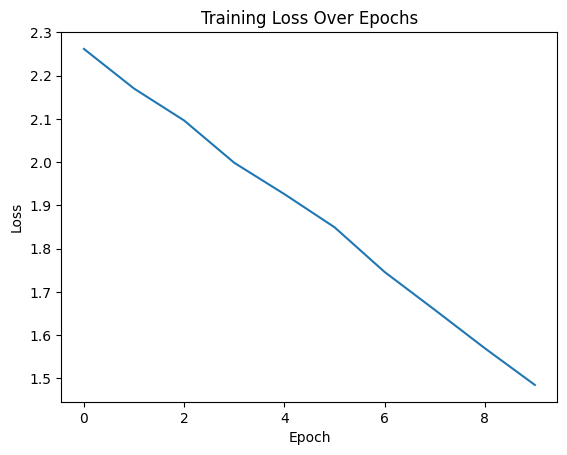

In [52]:
plt.plot(model.loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [53]:
accuracy = model.compute_accuracy(validation_data, validation_targets)
print(f"{accuracy:.2%}")

72.39%
